In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394115 sha256=dcf111bbb192ea85ad772b73334b3638994882dbcec8de3f2fd41e3803bc9833
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
#This notebook was tested on google colab
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing import image

In [ ]:
filePath = '/data'
ds_train, info = tfds.load(name="rock_paper_scissors:3.*.*", data_dir=filePath, split='train[:100%]', with_info=True)
ds_test = tfds.load(name="rock_paper_scissors:3.*.*", data_dir=filePath, split='test[:100%]')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /data/rock_paper_scissors/3.0.0.incompleteGY6JHF/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /data/rock_paper_scissors/3.0.0.incompleteGY6JHF/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /data/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


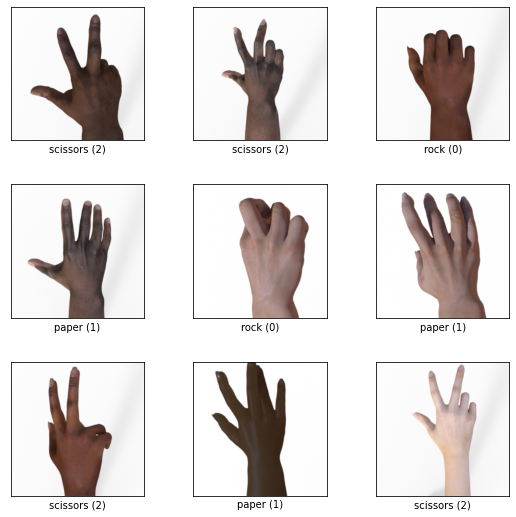

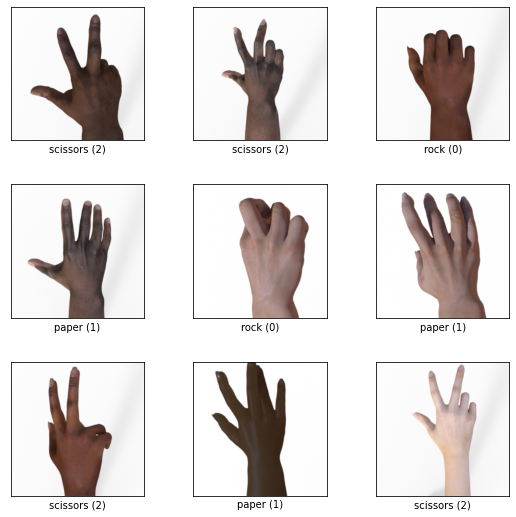

In [ ]:
tfds.show_examples(info, ds_train)

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Lambda(lambda x: x/255.0, input_shape=(224,224,3), name='lambda'),
                             hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/classification/4", trainable=False),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.7),
                             tf.keras.layers.Dense(10, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(3, activation='softmax')])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1001)              1692489   
_________________________________________________________________
batch_normalization (BatchNo (None, 1001)              4004      
_________________________________________________________________
dropout (Dropout)            (None, 1001)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10020     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

In [ ]:
def apply_transformation(ds):
    def resize_images(image_and_label):
        image_and_label['image'] = tf.image.resize(image_and_label['image'], size=(224,224),preserve_aspect_ratio=False,
                                                    antialias=False, name=None, method='nearest')
        image_and_label = tuple(image_and_label.values())
        return image_and_label
    ds = ds.map(resize_images)
    ds = ds.shuffle(320).batch(32)
    return ds

ds_train = ds_train.apply(apply_transformation)
ds_test = ds_test.apply(apply_transformation)


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(ds_train, validation_data=ds_test, epochs=3)

Epoch 1/3
79/79 [==============================] - 45s 571ms/step - loss: 0.4663 - accuracy: 0.8143 - val_loss: 0.3246 - val_accuracy: 0.8468
Epoch 2/3
79/79 [==============================] - 45s 569ms/step - loss: 0.1116 - accuracy: 0.9635 - val_loss: 0.2869 - val_accuracy: 0.8495
Epoch 3/3
79/79 [==============================] - 45s 570ms/step - loss: 0.0765 - accuracy: 0.9766 - val_loss: 0.3861 - val_accuracy: 0.8441


In [ ]:
model.save('/model1.h5')

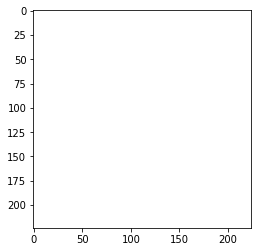

In [ ]:
import shap
import matplotlib.pyplot as plt

# select a set of background examples to take an expectation over
background = np.ones((224, 224, 3), dtype='float32')
plt.imshow(background)

In [ ]:
ds_test_shap = tfds.load(name="rock_paper_scissors:3.*.*", data_dir=filePath, split='test[:10%]')
def apply_transformation_shap(ds):
    def resize_images(image_and_label):
        image_and_label['image'] = tf.image.resize(image_and_label['image'], size=(224,224),preserve_aspect_ratio=False,
                                                    antialias=False, name=None, method='nearest')
        return image_and_label
    ds = ds.map(resize_images)
    return ds

ds_test_shap = ds_test_shap.apply(apply_transformation_shap)
X_y = list(tfds.as_numpy(ds_test_shap))

In [ ]:
X_test = np.array([i['image'] for i in X_y])
y_test = np.array([i['label'] for i in X_y])
print(X_test.shape)
print(y_test.shape)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
print(np.nonzero(y_test != y_pred))

(37, 224, 224, 3)
(37,)
(array([ 9, 20, 22, 25, 32]),)


In [ ]:
e = shap.GradientExplainer(model, background)

Using TensorFlow backend.


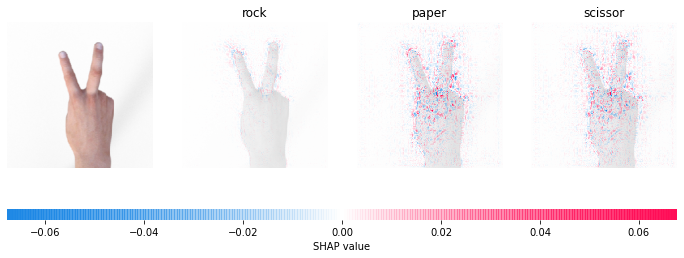

prediction : 2
actual : 2


In [ ]:
i = 0
shap_values = e.shap_values(X_test[i][None,:])
shap.image_plot(shap_values, X_test[i][None,:]*1.0, labels=np.array([['rock','paper','scissor']]))
print('prediction :', y_pred[i])
print('actual :', y_test[i])

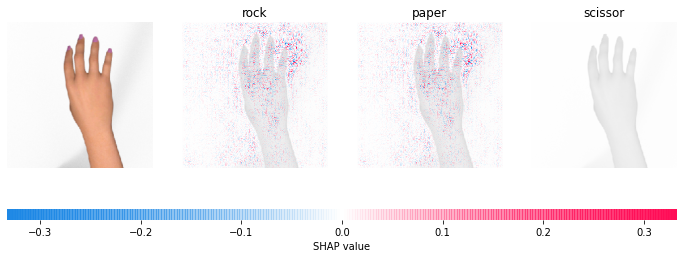

prediction : 0
actual : 1


In [ ]:
i = 6
shap_values = e.shap_values(X_test[i][None,:])
shap.image_plot(shap_values, X_test[i][None,:]*1.0, labels=np.array([['rock','paper','scissor']]))
print('prediction :', y_pred[i])
print('actual :', y_test[i])

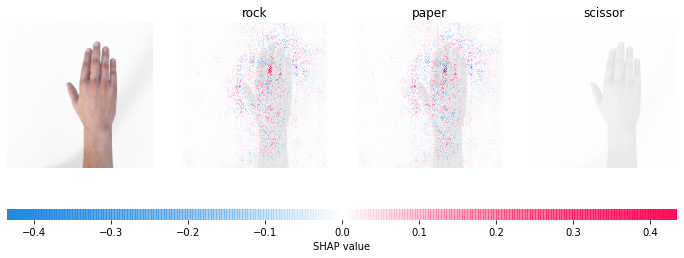

prediction : 0
actual : 1


In [ ]:
i = 9
shap_values = e.shap_values(X_test[i][None,:])
shap.image_plot(shap_values, X_test[i][None,:]*1.0, labels=np.array([['rock','paper','scissor']]))
print('prediction :', y_pred[i])
print('actual :', y_test[i])

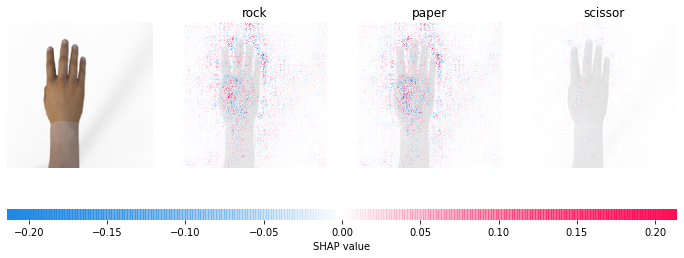

prediction : 0
actual : 1


In [ ]:
i = 20
shap_values = e.shap_values(X_test[i][None,:])
shap.image_plot(shap_values, X_test[i][None,:]*1.0, labels=np.array([['rock','paper','scissor']]))
print('prediction :', y_pred[i])
print('actual :', y_test[i])

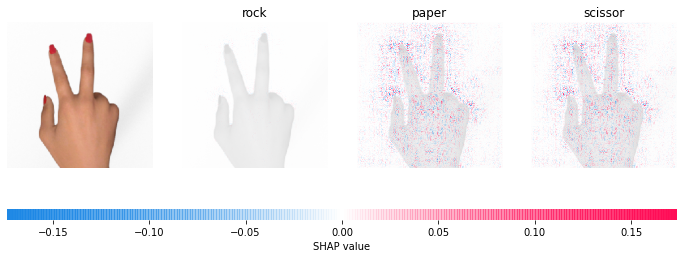

prediction : 1
actual : 2


In [ ]:
i = 25
shap_values = e.shap_values(X_test[i][None,:])
shap.image_plot(shap_values, X_test[i][None,:]*1.0, labels=np.array([['rock','paper','scissor']]))
print('prediction :', y_pred[i])
print('actual :', y_test[i])

Text(33.0, 0.5, 'actual')

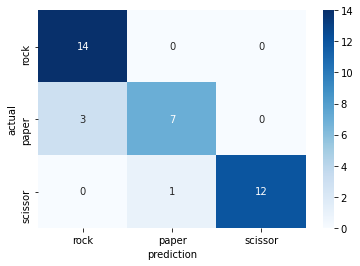

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, xticklabels=['rock', 'paper', 'scissor'], yticklabels=['rock', 'paper', 'scissor'])
plt.xlabel('prediction')
plt.ylabel('actual')

# **Tensorflow Gradient method**


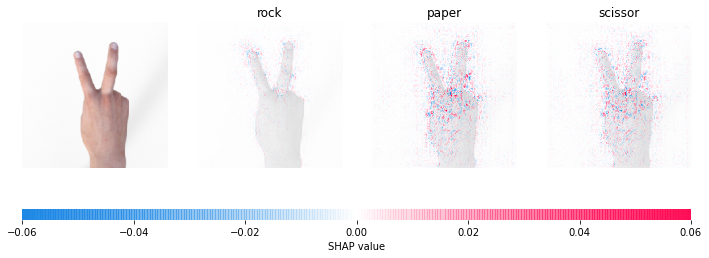

In [ ]:
def feature_steps_calc(default_input_feature, input_feature, num_steps):
    '''
    returns interpolated feature between default_input_feature and input_feature,
    with shape (num_steps, *(shape of input_feature))
    '''
    factor = np.linspace(0, 1, num_steps, dtype='float32')
    factor = tf.constant(factor)
    assert default_input_feature.shape == input_feature.shape, "deafult feature should be of same shape like feature"
    for _ in range(len(input_feature.shape)):
        factor = factor[:,tf.newaxis]
    feature_steps = default_input_feature + (factor * (input_feature-default_input_feature))
    return feature_steps

def gradients_calc(model, feature_steps, multi_output=True, output_index=0):
    '''
    returns gradients of output with respect to inputs at feature_steps,
    with shape (num_steps, *(shape of input_feature))
    '''
    with tf.GradientTape() as tape:
        tape.watch(feature_steps)
        y_pred = model(feature_steps)
        if multi_output == True:
            gradients = tape.gradient(y_pred[...,output_index], feature_steps)
        else:
            gradients = tape.gradient(y_pred, feature_steps)
    return gradients

def gradient_shap_calc(gradients, feature_steps):
    '''
    return integrated gradients as a proxy of shap values
    '''
    gradients = (gradients[:-1] + gradients[1:])/2
    feature_diff = feature_steps[1:] - feature_steps[:-1]
    gradient_shap = feature_diff * gradients
    gradient_shap = tf.reduce_sum(gradient_shap, axis=0)
    return gradient_shap

def integrated_gradients_calc(model, default_input_feature, input_feature, num_steps=100, multi_output=True, output_index=0):
    feature_steps = feature_steps_calc(default_input_feature, input_feature, num_steps)
    gradients = gradients_calc(model, feature_steps, multi_output=multi_output, output_index=output_index)
    shap_value = gradient_shap_calc(gradients, feature_steps)
    feature_steps = feature_steps_calc(default_input_feature, input_feature, num_steps)
    return shap_value

index = 0
shap_values = [integrated_gradients_calc(model, background, X_test[index], num_steps=100, output_index=i).numpy()[None,:] for i in range(3)]
shap.image_plot(shap_values, X_test[index][None,:]*1.0, labels=np.array([['rock','paper','scissor']]))